In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, gamma
%matplotlib inline

## ガンマ分布の描画

In [3]:
plt.style.use("ggplot")
# np.random.seed(123)

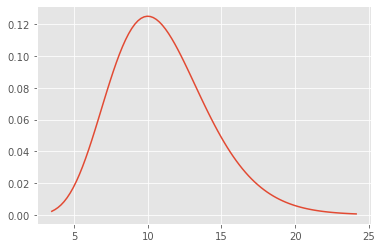

In [4]:
# パラメーターの初期値を設定
k = 11
lam = 1

# ガンマ分布の描画
x = np.linspace(gamma.ppf(0.001, k), gamma.ppf(0.999, k), 100)
plt.plot(x, gamma.pdf(x, k, scale=1/lam))

### ハミルトニアン
$H = \frac{1}{2}p^2 - (k-1)\log\theta + \lambda\theta$

## ハミルトニアンの偏微分
$\frac{\partial H}{\partial\theta} = -(k-1)\frac{1}{\theta} + \lambda$

$\frac{\partial H}{\partial p} = p$

## 正準方程式
$\frac{d\theta}{dt} = p$

$\frac{dp}{dt} = (k-1)\frac{1}{\theta} - \lambda$

## Leap-flog法

In [5]:
# f(θ)の傾き
f = lambda x, lam, k: (k-1) / x -lam

In [6]:
# Leap-flog法
def leap_flog(q, p, eps, lam, k, f):
    # 更新１：p(t+0.5) = p(t) + 0.5dp(t)
    p_new = p + 0.5 * eps * f(q, lam, k)
    # 更新２：q(t+1) = q(t) + dq(t+0.5)
    q_new = q + eps * p_new
    # 更新３：p(t+1) = p(t+0.5)+0.5dp(t+1)
    p_new = p_new + 0.5 * eps * f(q_new, lam, k)
    
    q, p = q_new, p_new
    return q, p

## ハミルトニアン　モンテカルロ法

d:\work\base_stan_prac\venv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


accept ratio:  1.0


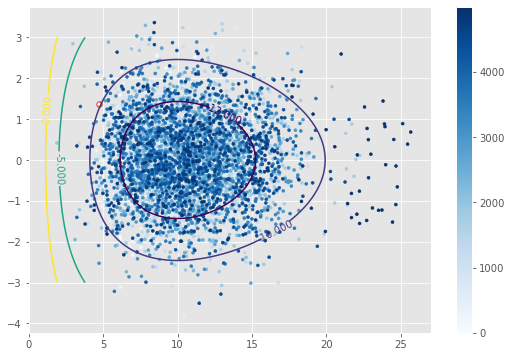

In [22]:
eps = 1e-2
q, p = 4.0, 0.0
L = 100
NMCS = 10000
warmup = 5000
lf_arr = np.zeros([NMCS,2])
n_accept = 0
for mcs in range(NMCS):
    hamiltonian_c = 0.5 * p ** 2 + lam * q - (k-1) * np.log(q)
    q_c, p_c = q, p 
    for i in range(L):
        q_c, p_c = leap_flog(q_c, p_c, eps, lam, k, f)
    hamiltonian_new = 0.5 * p_c ** 2 + lam * q_c - (k-1) * np.log(q_c)
    if np.random.rand() < np.exp(hamiltonian_c - hamiltonian_new):
        q, p = q_c, p_c
        hamiltonian_c = hamiltonian_new
        n_accept += 1
    lf_arr[mcs,:] = q,p
    p = norm.rvs()
df = pd.DataFrame(lf_arr[:warmup], columns=["q","p"])
plt.figure(figsize=(9,6))
x, y = np.linspace(0, 20, 100), np.linspace(-3,3, 100)
X, Y = np.meshgrid(x,y)
CS = plt.contour(X, Y, 0.5 * Y ** 2 - (k-1)*np.log(X) + lam * X, levels = [-12, -10, -5, 0])
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(df["q"][0],df["p"][0])
plt.scatter(df["q"],df["p"], marker=".", c = df.index, cmap="Blues")
plt.colorbar()
print("accept ratio: ", n_accept / NMCS)

d:\work\base_stan_prac\venv\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


accept raetio:  0.9999


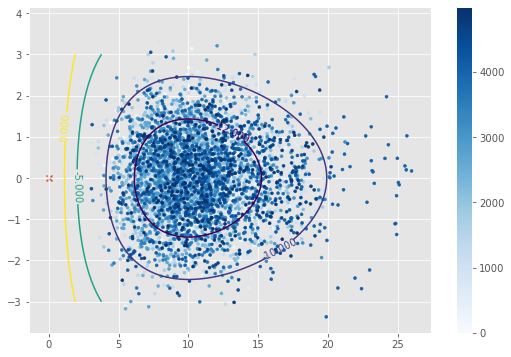

In [23]:
# パラメータの設定
# 10^-2
eps = 1e-2
q, p = 4.0, 0.0
L = 100
NMCS = 10000
warmup = 5000

lf_arr = np.zeros([NMCS, 2])
n_accept = 0
p_arr = []
for mcs in range(1, NMCS):
    # 現在のハミルトニアンを計算する
    hamiltonian_c = 0.5 * p**2 - (k-1)*np.log(q) + lam * q
    # 現在のq,pを設定
    q_c, p_c = q, p
    # L回更新
    for i in range(L):
        # Leap-flop法で更新
        q_c, p_c = leap_flog(q_c, p_c, eps, lam, k, f)
    # L回更新後にハミルトニアンを計算する
    hamiltonian_new = 0.5 * p_c ** 2 -(k-1) * np.log(q_c) + lam * q_c
    # 更新前のハミルトニアンとL回更新後にハミルトニアンの値を比較
    if np.random.rand() < np.exp(hamiltonian_c - hamiltonian_new):
        # 更新前後でハミルトニアンが等しい場合、受け入れることになる（右辺＝１なので）
        # 更新後のハミルトニアンの方が大きい場合、右辺＜１なので、受け入れることがある
        # 更新前のハミルトニアンが大きい場合、右辺＞１なので受け入れる
        # 受け入れる場合はq, p, ハミルトニアンを更新する
        q, p = q_c, p_c
        hamiltonian_c = hamiltonian_new
        n_accept += 1
    lf_arr[mcs, :] = q, p
    # pを正規分布（μ＝0、σ＝1）に従う値で新しく設定する
    p = norm.rvs()
    p_arr.append(p)
df = pd.DataFrame(lf_arr[:warmup], columns=["q", "p"])

# 描画
plt.figure(figsize=(9,6))

# ガンマ分布とハミルトニアンの等高線
# ガンマ分布の可視化
x, y = np.linspace(0, 20, 100), np.linspace(-3,3,100)
X, Y = np.meshgrid(x, y)
# ハミルトニアンの等高線
CS = plt.contour(X, Y, 0.5 * Y**2 - (k-1)*np.log(X) + lam * X, levels=[-12, -10, -5, 0])
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(df["q"][0], df["p"][0], marker="x")
plt.scatter(df["q"], df["p"], marker=".", c = df.index, cmap="Blues")
plt.colorbar()
print("accept raetio: ", n_accept / NMCS)
# print("p:", p)

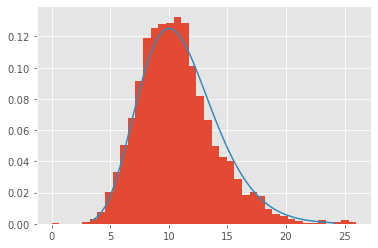

In [24]:
df["q"].hist(normed=True, bins=40)
# ガンマ分布の描画
x = np.linspace(gamma.ppf(0.001, k), gamma.ppf(0.999, k), 100)
plt.plot(x, gamma.pdf(x, k, scale=1/lam))